<a href="https://colab.research.google.com/github/alyahoang99/classfication-clustering/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling
!pip install pywaffle
!pip install highlight_text
!pip install Waffle

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import os
import yellowbrick
import joblib

from ydata_profiling import ProfileReport
from highlight_text import HighlightText, ax_text, fig_text
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model  import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, davies_bouldin_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.style import set_palette
from pywaffle import Waffle


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classification&Clustering/Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
## data report
ProfileReport(df, title='Iris Dataset Report', minimal=True
              , progress_bar=False, samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe': {'height': '600px'}},
              html={'style': {'primary_color': 'red'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

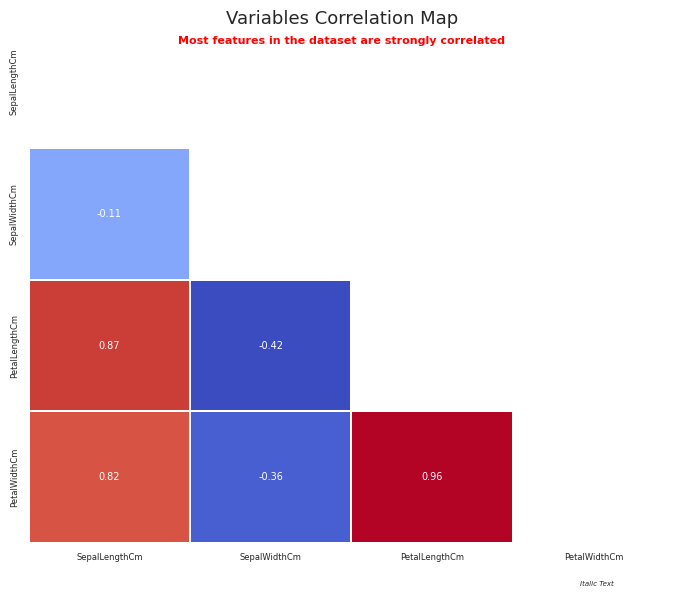

In [ ]:
# Define parameters
suptitle_params = dict(x=0.5, y=0.96, fontsize=13, ha='center', va='bottom', fontname='Arial')
title_params = dict(x=0.5, y=0.93, fontsize=8, ha='center', va='bottom', fontname='Arial')
xy_label_params = dict(size=6)
highlight_textprops = {'weight': 'bold', 'color': 'red'}

# Create correlation map DataFrame
df_corr = df.drop(columns=['Species', 'Id'])

# Create heatmap
mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df_corr.corr(), mask=mask, annot=True, cmap='coolwarm', linewidths=0.2, cbar=False, annot_kws={'size': 7}, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, **xy_label_params)
ax.set_yticklabels(ax.get_yticklabels(), **xy_label_params)
ax.grid(False)
fig.text(s='Variables Correlation Map', **suptitle_params)
fig.text(s='Most features in the dataset are strongly correlated', **title_params, **highlight_textprops)
plt.tight_layout(rect=[0, 0.04, 1, 1.01])
plt.gcf().text(0.84, 0.03, 'Italic Text', style='italic', fontsize=5)
plt.show()


From dataset report and correlation matrix, it can be concluded that:
- From the skewness values of each column, it can be concluded that all columns in the dataset have an approximately normal distribution (the value between -0.5 to 0.5). This alos proven in the mean and median values in each column, where the mean value is not much different from the median.
- most features in the dataset are strongly correlated to each other.

# EDA
## Numerical Variables Pairplot

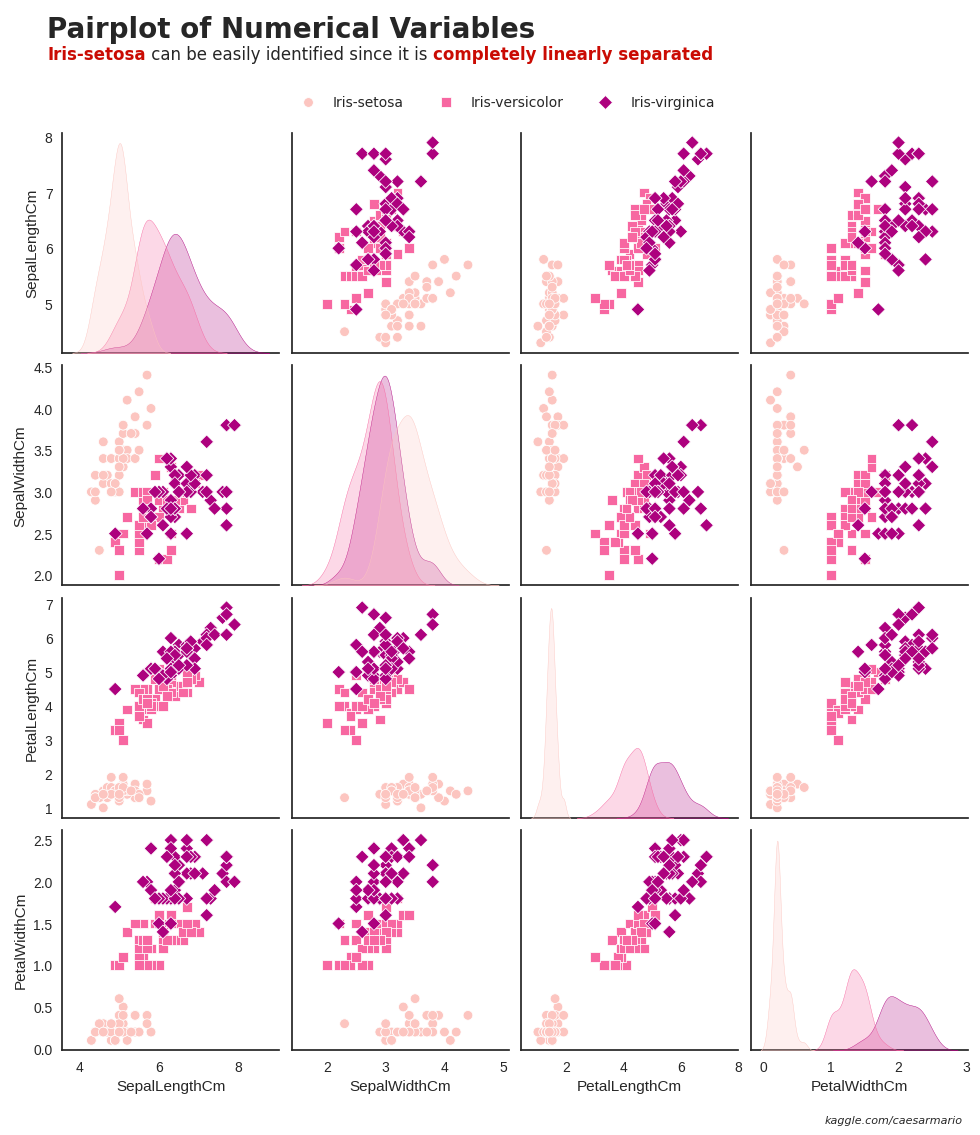

In [ ]:
# variables
font_main = 'Arial'
font_alt = 'Times New Roman'
colors = 'red'

subtitle = dict(x=0.05, y=1.07, fontsize=20, weight='heavy', ha='left', va='bottom', fontname=font_main)
title = dict(x=0.05, y=1.05, fontsize=12, weight='normal', ha='left', va='bottom', fontname=font_alt)
highlight_textprops = [{'weight': 'bold', 'color': colors[0]}, {'weight': 'bold', 'color': colors[0]}]


# Define color palette cmap
color_eda = 'RdPu'
sns.set_palette("pastel")

# Display variables
with sns.axes_style('white'):
    eda1 = sns.pairplot(df, hue='Species', diag_kind='kde', palette=color_eda, markers=['o','s','D'], vars=df_corr)
eda1_handles, eda1_labels = eda1._legend_data.values(), eda1._legend_data.keys()
eda1._legend.remove()
eda1.fig.legend(handles=eda1_handles, labels=eda1_labels, loc='upper center', ncol=3, bbox_to_anchor=(0.45, 1.03))
fig_text(s='Pairplot of Numerical Variables', **subtitle)
fig_text(s='<Iris-setosa> can be easily identified since it is <completely linearly separated>', highlight_textprops=highlight_textprops, **title)
plt.gcf().text(0.73, -0.01, 'kaggle.com/caesarmario', style='italic', fontsize=8)
plt.show()


Petal length and petal width are that the most useful variables to identify iris types. Iris-virginica and Iris-versicolor have some overlap in its distributions (almost linearly separated) while Iris-setosa can be easily identified since it is completely linearly separated.

## Sepal Length and Sepal Width Jointplot

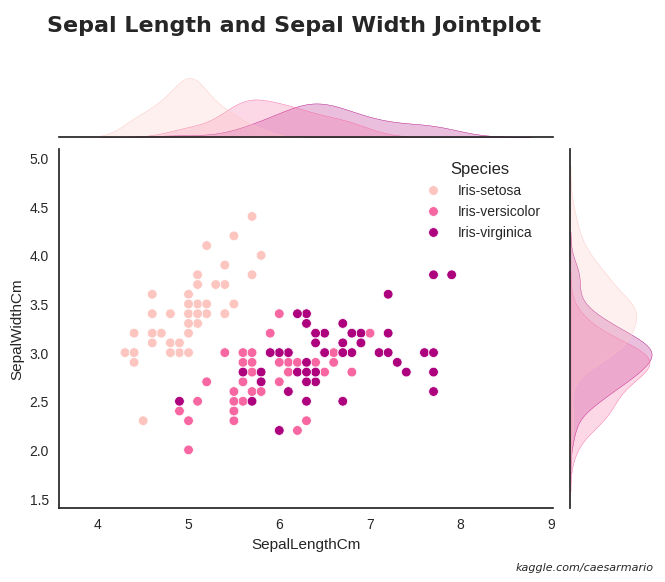

In [ ]:
# variables
suptitle = dict(x=0.1, y=1.05, fontsize=16, weight='heavy', ha='left', va='bottom', fontname=font_main)
title = dict(x=0.1, y=1.02, fontsize=8, weight='normal', ha='left', va='bottom', fontname=font_alt)
highlight_textprops = [{'weight': 'bold', 'colors': colors[0]}, {'weight': 'bold', 'color': colors[0]}]
# display EDA 2
with sns.axes_style('white'):
  eda2 = sns.jointplot(x='SepalLengthCm', y='SepalWidthCm', data=df, hue='Species', palette=color_eda)
eda2.fig.set_size_inches((7, 5))
fig_text(s="Sepal Length and Sepal Width Jointplot", **suptitle)
#fig_text(s="<Iris-setosa> is more likely to have a <short sepal length but a broader sepal breadth>.", highlight_textprops=highlight_textprops, **title)
plt.gcf().text(0.77, -0.02, "kaggle.com/caesarmario", style="italic", fontsize=8)
plt.show();

Iris-setosa can be separated by using sepal length and sepal witdth. However, separating Iris-versicolor from Iris-virginica is harder since the distributions is overlapping. Iris-setosa, on the other hand, is more likely to have a short sepal length but a broader sepal breadth.

## Numerical Variables Distributions

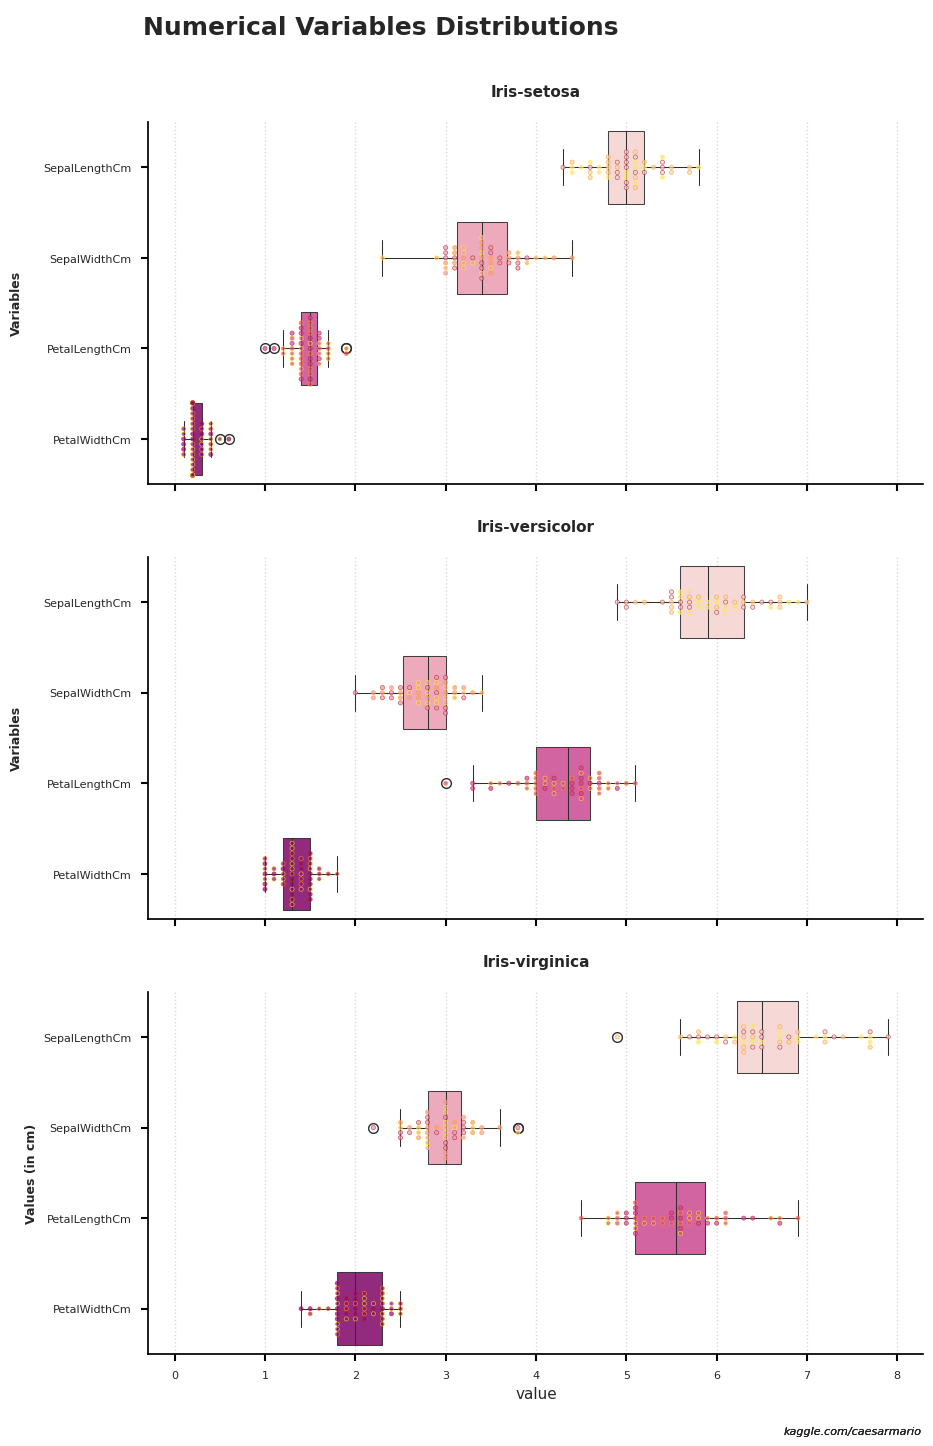

In [ ]:
# EDA 3 Variables

color_line = 'black'
scatter_color_edge = ['orange', 'brown', 'yellow']
color_grid = 'grey'
colors = 'RdPu'
color_eda = 'Red'
font_main = 'DejaVu Sans'
tick_params_prompt = dict(labelsize=8, length=5, width=1.5, bottom='on', color=color_line)
plot_style = dict(edgecolor = scatter_color_edge, s=3, alpha=0.7)
tick_params = dict(length=3, width=1, color=color_line)
xy_label = dict(fontsize=9, weight='bold')
highlight_textprops = [{'weight':'bold', 'color': colors[0]}, {'weight':'bold','color':colors[0]}]
suptitle = dict(x=0.12, y=0.932, fontsize=18, weight='heavy',ha='left', va='bottom', fontname=font_main)
title = dict(x=0.12, y=0.92, fontsize=10, weight='normal', ha='left', va='bottom', fontname=font_main)
column_list2 = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
# EDA3 function
def boxplot_figure(iris_type):
  df_eda3 = df[column_list2][df.Species==iris_type]
  if iris_type == 'Iris-setosa': ax_num = 0
  elif iris_type == 'Iris-versicolor': ax_num = 1
  elif iris_type == 'Iris-virginica': ax_num = 2
  fig = sns.boxplot(x='value', y='variable', data=pd.melt(df_eda3), ax=axs[ax_num], palette=colors, boxprops=dict(alpha=0.9), linewidth=0.75)
  fig = sns.swarmplot(x='value', y='variable', data=pd.melt(df_eda3), ax=axs[ax_num], palette=colors, linewidth=0.5, size=3.5, **plot_style)
  fig.set_title(f'{iris_type}\n', fontweight='heavy', fontsize='11')
  fig.set_ylabel('Variables\n', **xy_label)
  if iris_type in ['Iris-setosa', 'Iris-versicolor']:
    fig.set_xlabel('', **xy_label)
  else:
    fig.set_ylabel('\nValues (in cm)', **xy_label)
  fig.grid(axis='y', alpha=0, zorder=2)
  fig.grid(axis='x', which='major', alpha=0.3, color=color_grid, linestyle='dotted', zorder=1)
  for spine in fig.spines.values():
    spine.set_color('None')
  for spine in ['bottom', 'left']:
    fig.spines[spine].set_visible(True)
    fig.spines[spine].set_color(color_line)
  fig.tick_params(axis='both', which='major', left='on', **tick_params_prompt)
  fig.tick_params(axis='x', which='minor', **tick_params_prompt)
  plt.gcf().text(0.76, 0.06,"kaggle.com/caesarmario", style="italic", fontsize=8)

# display EDA 3
fig, axs = plt.subplots(3, 1, figsize=(10,16), sharex=True, sharey=True)
for iris_type in list(df['Species'].unique()): boxplot_figure(iris_type)
fig_text(s='Numerical Variables Distributions', **suptitle)
#fig_text(s='<Iris-setosa> is having smaller features and less distributed while <Iris-virginica is the opposite>', highlight_textprops=highlight_textpros, **title)
plt.show();

## Data Preprocessing
### Dropping variable, features separating and splitting

Id column will be removed since this column contain unique data. Also, the Species column will be separated from other columns and the dataset will be splitted into 80:20 ratio, which 80% training and 20% testing.

In [ ]:
# dropping 'id' from dataframe
df = df.drop('Id', axis=1)

# separating 'Species' column
x = df.drop(['Species'], axis=1)
y = df['Species']

# Splitting Dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Processing Pipeline

In [ ]:
# pipeline

pipeline = Pipeline([
    ('scaling', StandardScaler())
])

# apply pipeline to DataFrame
x_train_process = pipeline.fit_transform(x_train)
x_test_process = pipeline.fit_transform(x_test)

# Supervised Model Implementation [link text](https://)

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features import FeatureImportances

# Define custom color palette
color_yb = ['#FF5733', '#33FF57', '#3357FF']
color_grid = 'grey'
color_line = 'black'
colors_yb_importance = 'pink'

# Define the Clr class for color formatting
class Clr:
    start = '\033[91m'  # Start color (red)
    end = '\033[0m'     # End color (reset)

clr = Clr()
iris_list = ['Setosa', 'Versicolor', 'Virginica']

def fit_ml_models(algo, algo_param, algo_name):
    # Create an algorithm pipeline
    algo = Pipeline([('algo', algo)])

    # Apply grid search
    model = GridSearchCV(algo, param_grid=algo_param, cv=10, n_jobs=-1, verbose=1)

    # Fitting the model
    print(clr.start + f'.:. Fitting {algo_name} .:.' + clr.end)
    fit_model = model.fit(x_train_process, y_train)

    # Get best parameters
    best_params = model.best_params_
    print('\n>> Best Parameters: ' + clr.start + f'{best_params}' + clr.end)

    # Get best & final estimators
    best_model = model.best_estimator_
    best_estimator = model.best_estimator_._final_estimator
    best_score = round(model.best_score_, 4)
    print('>> Best Score: ' + clr.start + '{:.3f}'.format(best_score) + clr.end)

    # Create prediction for Train & Test
    y_pred_train = model.predict(x_train_process)
    y_pred_test = model.predict(x_test_process)

    # Train & test accuracy score
    acc_score_train = round(accuracy_score(y_pred_train, y_train) * 100, 3)
    acc_score_test = round(accuracy_score(y_pred_test, y_test) * 100, 3)
    print('\n' + clr.start + f'.:. Train and Test Accuracy Score for {algo_name} .:.' + clr.end)
    print('\t>> Train Accuracy:' + clr.start + '{:.2f}%'.format(acc_score_train) + clr.end)
    print('\t>> Test Accuracy:' + clr.start + '{:.2f}%'.format(acc_score_test) + clr.end)

    # Classification report
    print('\n' + clr.start + f'.:. Classification Report for {algo_name} .:.' + clr.end)
    print(classification_report(y_test, y_pred_test))

    # Figure settings
    xy_label = dict(fontweight='bold', fontsize=12)
    grid_style = dict(color=color_grid, linestyle='dotted', zorder=1)
    title_style = dict(fontsize=14, fontweight='bold')
    tick_params = dict(length=3, width=1, color=color_line)

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # Confusion matrix
    conf_matrix = ConfusionMatrix(best_estimator, ax=axes[0, 0], cmap='BuPu')
    conf_matrix.fit(x_train_process, y_train)
    conf_matrix.score(x_test_process, y_test)
    conf_matrix.finalize()
    conf_matrix.ax.set_title('Confusion Matrix \n', **title_style)
    conf_matrix.ax.tick_params(axis='both', labelsize=10, bottom='on', left='on', **tick_params)
    for spine in conf_matrix.ax.spines.values(): spine.set_color(color_line)
    conf_matrix.ax.set_xlabel('\nPredicted Class', **xy_label)
    conf_matrix.ax.set_ylabel('True Class\n', **xy_label)
    conf_matrix.ax.xaxis.set_ticklabels(iris_list, rotation=0)
    conf_matrix.ax.yaxis.set_ticklabels(iris_list[::-1])

    # ROC AUC
    roc_auc = ROCAUC(best_estimator, classes=iris_list, ax=axes[0, 1], colors=color_yb)
    roc_auc.fit(x_train_process, y_train)
    roc_auc.score(x_test_process, y_test)
    roc_auc.finalize()
    roc_auc.ax.set_title('ROC AUC Curve\n', **title_style)
    roc_auc.ax.tick_params(axis='both', labelsize=10, bottom='on', left='on', **tick_params)
    roc_auc.ax.grid(axis='both', alpha=0.4, **grid_style)
    for spine in roc_auc.ax.spines.values(): spine.set_color('None')
    for spine in ['bottom', 'left']:
        roc_auc.ax.spines[spine].set_visible(True)
        roc_auc.ax.spines[spine].set_color(color_line)
    roc_auc.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, borderpad=2, frameon=False, fontsize=10)
    roc_auc.ax.set_xlabel('\nFalse Positive Rate', **xy_label)
    roc_auc.ax.set_ylabel('True Positive Rate\n', **xy_label)

    # Learning curve
    lcurve = LearningCurve(best_estimator, scoring='f1_weighted', ax=axes[1, 0], colors=color_yb)
    lcurve.fit(x_train_process, y_train)
    lcurve.finalize()
    lcurve.ax.set_title('Learning Curve\n', **title_style)
    lcurve.ax.grid(axis='both', alpha=0.4, **grid_style)
    for spine in lcurve.ax.spines.values(): spine.set_color('None')
    for spine in ['bottom', 'left']:
        lcurve.ax.spines[spine].set_visible(True)
        lcurve.ax.spines[spine].set_color(color_line)
    lcurve.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, borderpad=2, frameon=False, fontsize=10)
    lcurve.ax.set_xlabel('\nTraining Instances', **xy_label)
    lcurve.ax.set_ylabel('Scores\n', **xy_label)

    # Feature importance or Precision Recall Curve
    try:
        feat_importance = FeatureImportances(best_estimator, labels=column_list2, ax=axes[1, 1], colors=colors_yb_importance)
        feat_importance.fit(x_train_process, y_train)
        feat_importance.finalize()
        feat_importance.ax.set_title('Feature Importance\n', **title_style)
        feat_importance.ax.tick_params(axis='both', labelsize=10, bottom='on', left='on', **tick_params)
        feat_importance.ax.grid(axis='x', alpha=0.4, **grid_style)
        feat_importance.ax.grid(axis='y', alpha=0, **grid_style)
        for spine in feat_importance.ax.spines.values(): spine.set_color('None')
        for spine in ['bottom']:
            feat_importance.ax.spines[spine].set_visible(True)
            feat_importance.ax.spines[spine].set_color(color_line)
        feat_importance.ax.set_xlabel('\nRelative Importance', **xy_label)
        feat_importance.ax.set_ylabel('Features\n', **xy_label)
    except Exception as e:
        print("Feature importance visualization failed:", e)
        prec_curve = PrecisionRecallCurve(best_estimator, ax=axes[1, 1], ap_score=True, iso_f1_curves=True)
        prec_curve.fit(x_train_process, y_train)
        prec_curve.score(x_test_process, y_test)
        prec_curve.finalize()
        prec_curve.ax.set_title('Precision-Recall Curve\n', **title_style)
        prec_curve.ax.tick_params(axis='both', labelsize=10, bottom='on', left='on', **tick_params)
        for spine in prec_curve.ax.spines.values(): spine.set_color('None')
        for spine in ['bottom', 'left']:
            prec_curve.ax.spines[spine].set_visible(True)
            prec_curve.ax.spines[spine].set_color(color_line)
        prec_curve.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, borderpad=2, frameon=False, fontsize=10)
        prec_curve.ax.set_xlabel('\nRecall', **xy_label)
        prec_curve.ax.set_ylabel('Precision\n', **xy_label)

    plt.suptitle(f'\n{algo_name} Performance Evaluation Report\n', fontsize=18, fontweight='bold')
    plt.gcf().text(0.88, 0.02, "kaggle.com/caesarmario", style="italic", fontsize=10)
    plt.tight_layout()
    plt.show()

    return acc_score_train, acc_score_test, best_score


## Logistic regression


.:. Fitting Logistic Regression .:.
Fitting 10 folds for each of 30 candidates, totalling 300 fits

>> Best Parameters: {'algo__C': 10, 'algo__max_iter': 100, 'algo__solver': 'newton-cg'}
>> Best Score: 0.958

.:. Train and Test Accuracy Score for Logistic Regression .:.
	>> Train Accuracy:98.33%
	>> Test Accuracy:96.67%

.:. Classification Report for Logistic Regression .:.
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



Feature importance visualization failed: Invalid RGBA argument: 'p'


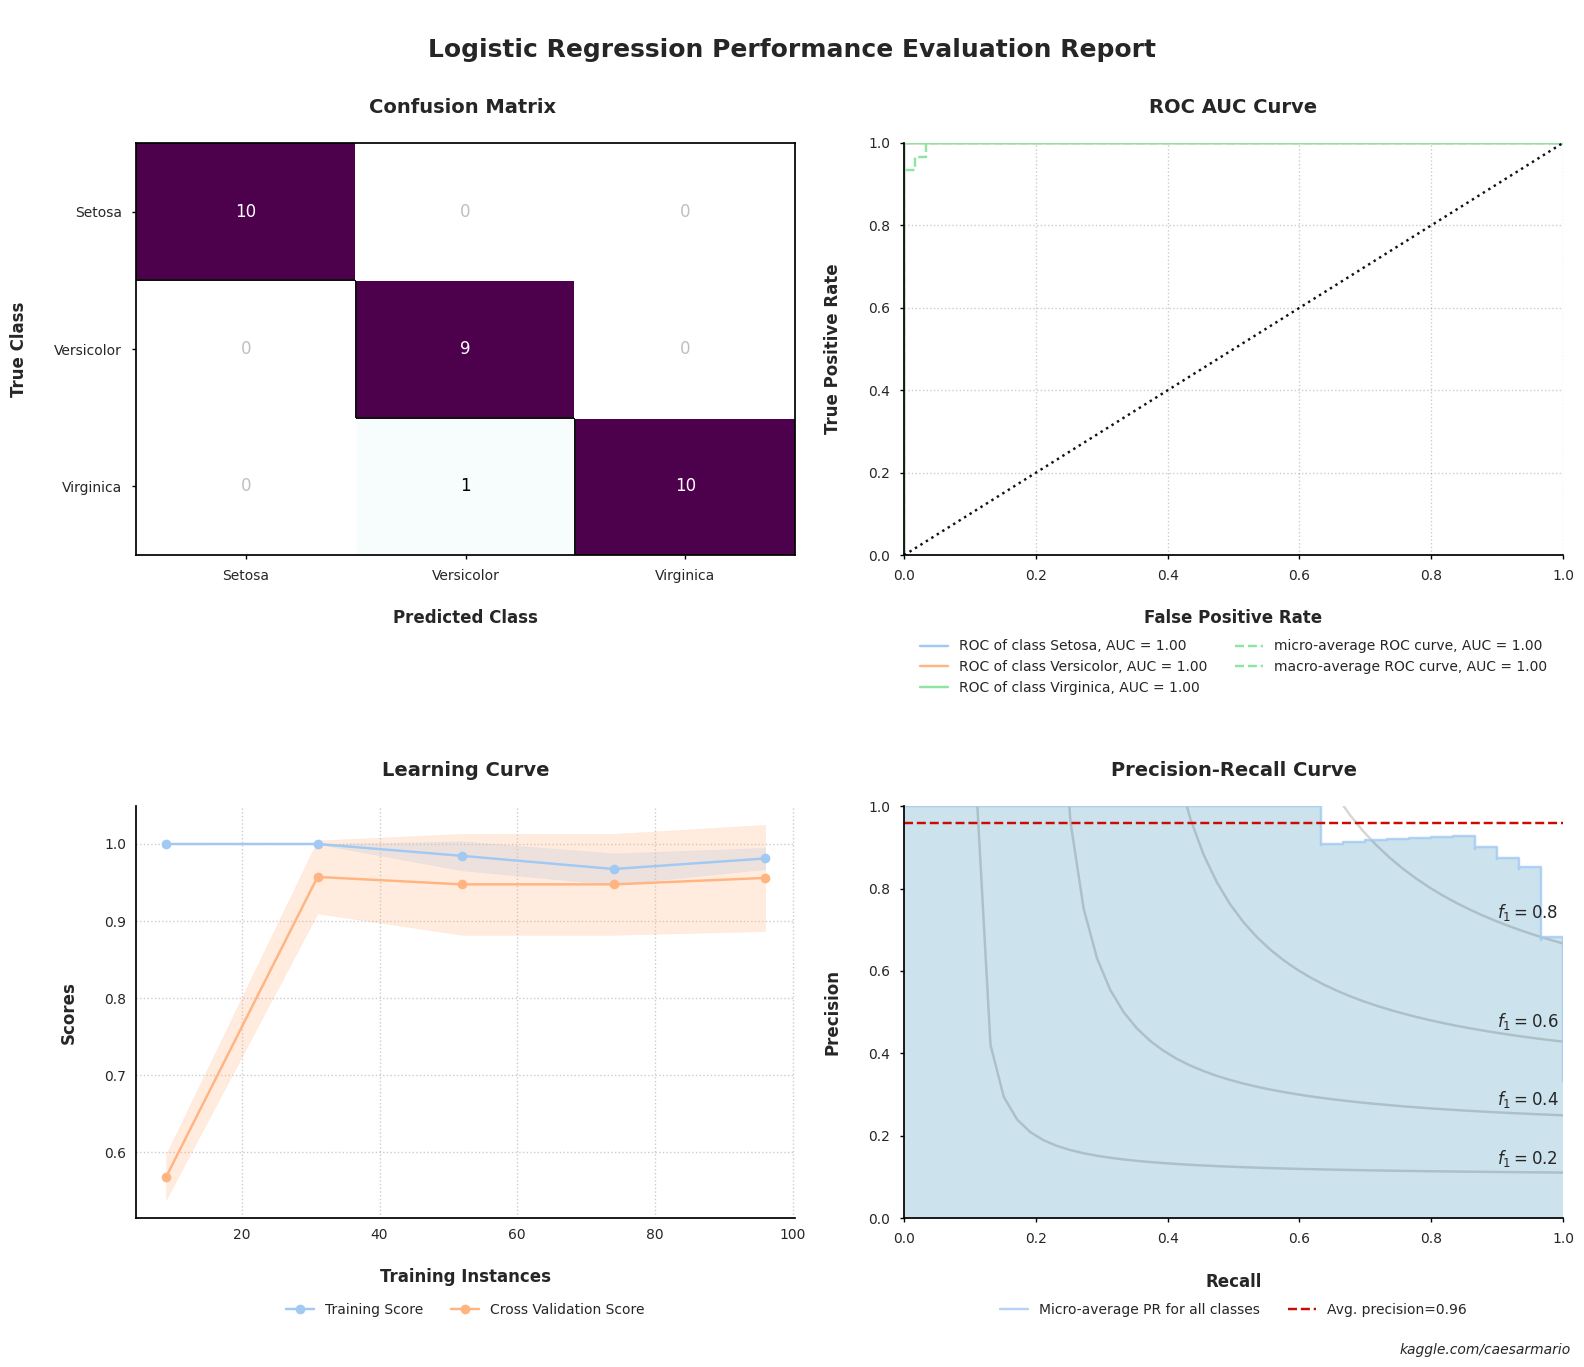

Training Accuracy: 98.333
Testing Accuracy: 96.667
Best Cross-Validation Score: 0.9583


In [ ]:
import warnings
warnings.filterwarnings("ignore")
algo_lr = LogisticRegression(penalty='l2', random_state=42)
parameter_lr = {
    'algo__solver': ['liblinear', 'newton-cg'],
    'algo__C': [0.001, 0.01, 0.1, 1, 10],
    'algo__max_iter': [100, 200, 300]
}

# Assuming x_train_process, y_train, x_test_process, y_test are defined
acc_score_train_lr, acc_score_test_lr, best_score_lr = fit_ml_models(
    algo_lr, parameter_lr, 'Logistic Regression'
)

print(f'Training Accuracy: {acc_score_train_lr}')
print(f'Testing Accuracy: {acc_score_test_lr}')
print(f'Best Cross-Validation Score: {best_score_lr}')

## Support Vector Machine (SVM)

The goal of the SVM algorithm is to create the best line for decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called hyperlane.
SVM chooses the extreme points/vectors that help in creating the hyperlane. These extreme cases are called as support vectors, and hence algorithm is termed as SVM.

.:. Fitting Support Vector Machine (SVM) .:.
Fitting 10 folds for each of 171 candidates, totalling 1710 fits

>> Best Parameters: {'algo__C': 0.4, 'algo__kernel': 'linear'}
>> Best Score: 0.958

.:. Train and Test Accuracy Score for Support Vector Machine (SVM) .:.
	>> Train Accuracy:96.67%
	>> Test Accuracy:96.67%

.:. Classification Report for Support Vector Machine (SVM) .:.
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



Feature importance visualization failed: Invalid RGBA argument: 'p'


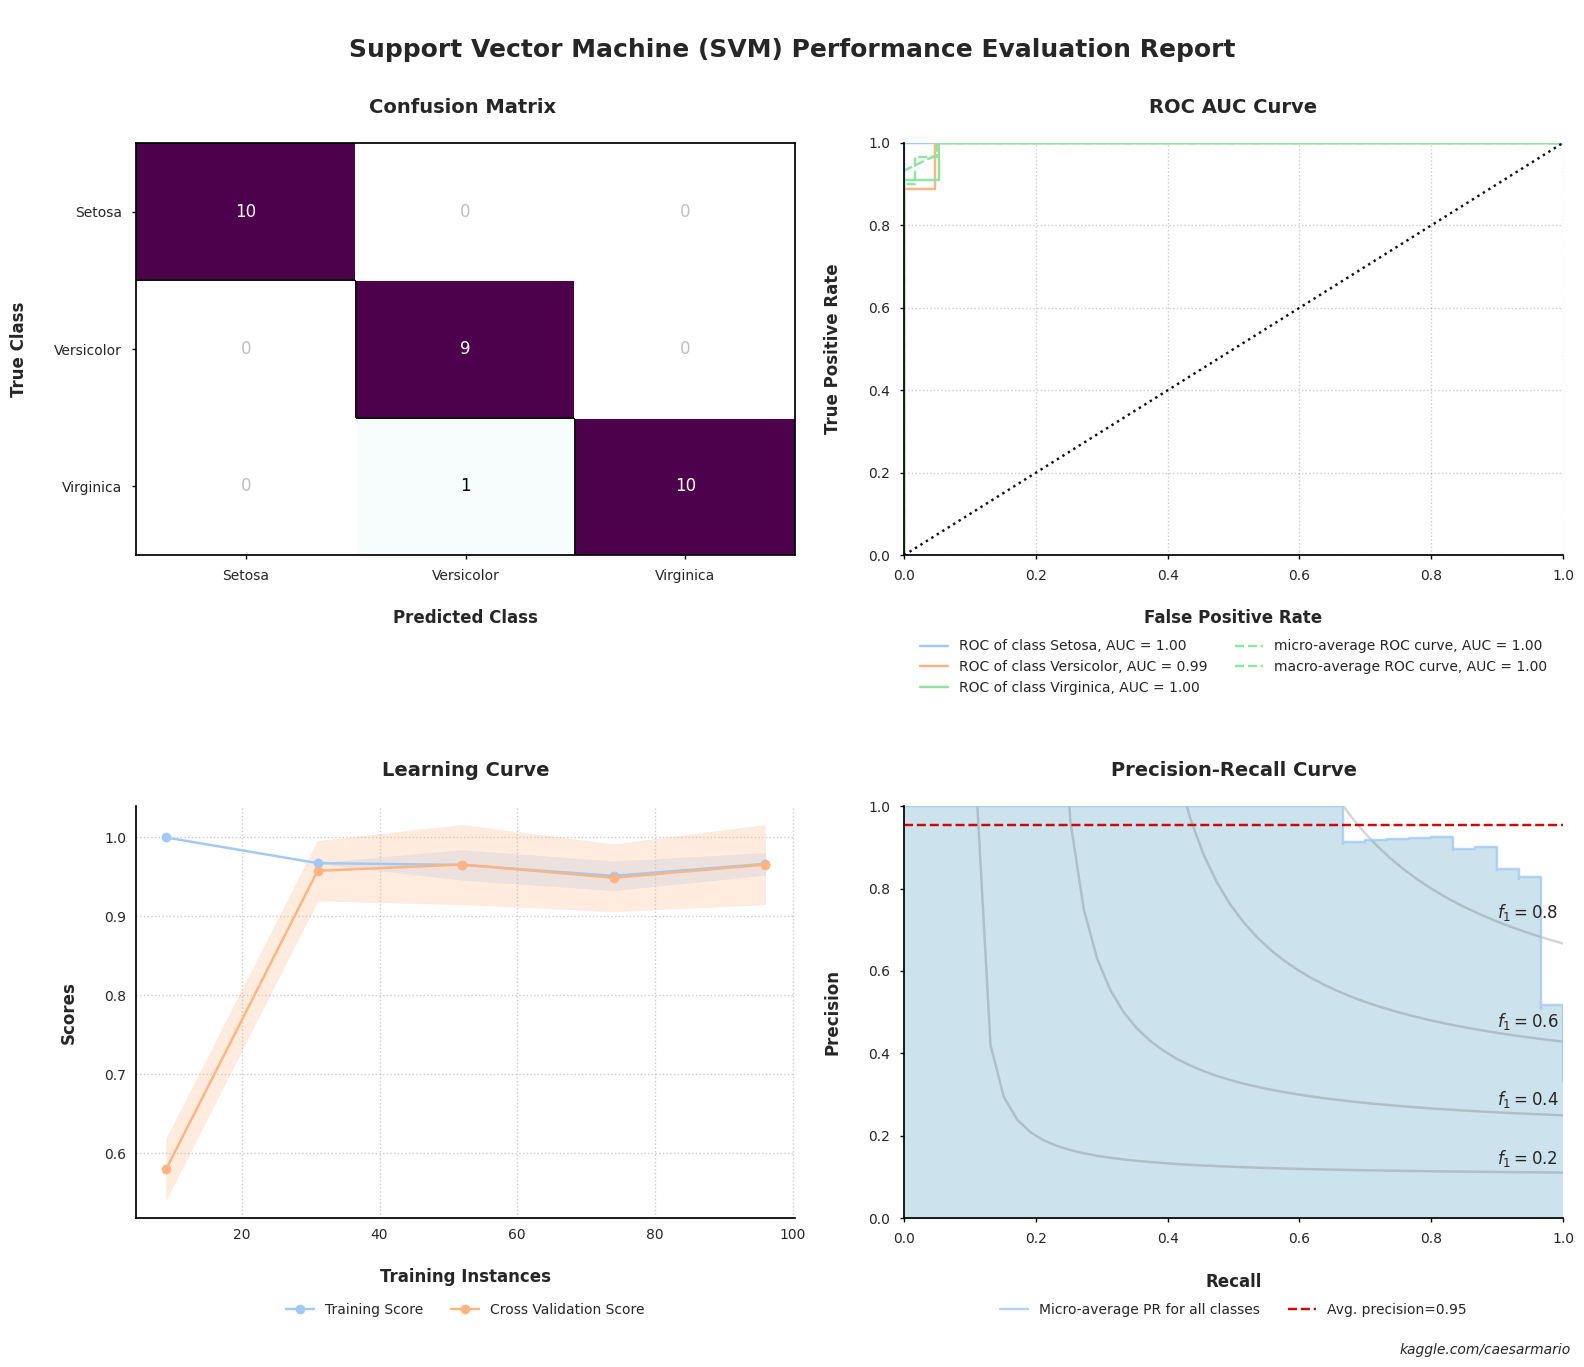

Training Accuracy: 98.333
Testing Accuracy: 96.667
Best Cross-Validation Score: 0.9583


In [ ]:
# --- SVM Parameters ---
parameter_svc = [
    {"algo__kernel": ["rbf"], "algo__gamma": np.arange(0.1, 1, 0.1), "algo__C": np.arange(0.1, 1, 0.1)}
    , {"algo__kernel": ["linear"], "algo__C": np.arange(0.1, 1, 0.1)}
    , {"algo__kernel": ["poly"], "algo__degree" : np.arange(1, 10, 1), "algo__C": np.arange(0.1, 1, 0.1)}
]

# --- SVM Algorithm ---
algo_svc = SVC(random_state=1, probability=True)

# --- Applying SVM ---
acc_score_train_svc, acc_score_test_svc, best_score_svc = fit_ml_models(algo_svc, parameter_svc, "Support Vector Machine (SVM)")

print(f'Training Accuracy: {acc_score_train_lr}')
print(f'Testing Accuracy: {acc_score_test_lr}')
print(f'Best Cross-Validation Score: {best_score_lr}')

## K-Nearest Neighbour (KNN)

The KNN algorithm is a data classification method for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to. The KNN algorithm is a type of supervised machine learning algorithm used to solve classification and regression problems.
It's called lazy learning algorithm or lazy learner because it does not perform any training when you supply the training data. Instead, it just stores the data during the training time and does not perform any calculations. It does not build a model until a query is performed on the dataset. This makes KNN ideal for data mining.
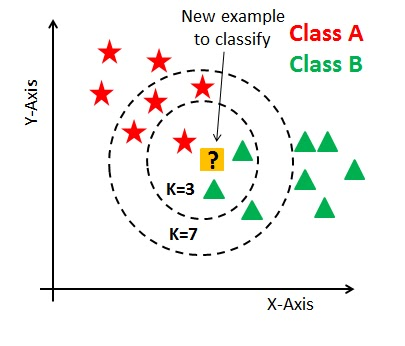

.:. Fitting K-Nearest Neighbour (KNN) .:.
Fitting 10 folds for each of 130 candidates, totalling 1300 fits

>> Best Parameters: {'algo__leaf_size': 1, 'algo__n_neighbors': 11}
>> Best Score: 0.958

.:. Train and Test Accuracy Score for K-Nearest Neighbour (KNN) .:.
	>> Train Accuracy:95.83%
	>> Test Accuracy:96.67%

.:. Classification Report for K-Nearest Neighbour (KNN) .:.
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



Feature importance visualization failed: could not find feature importances param on KNeighborsClassifier


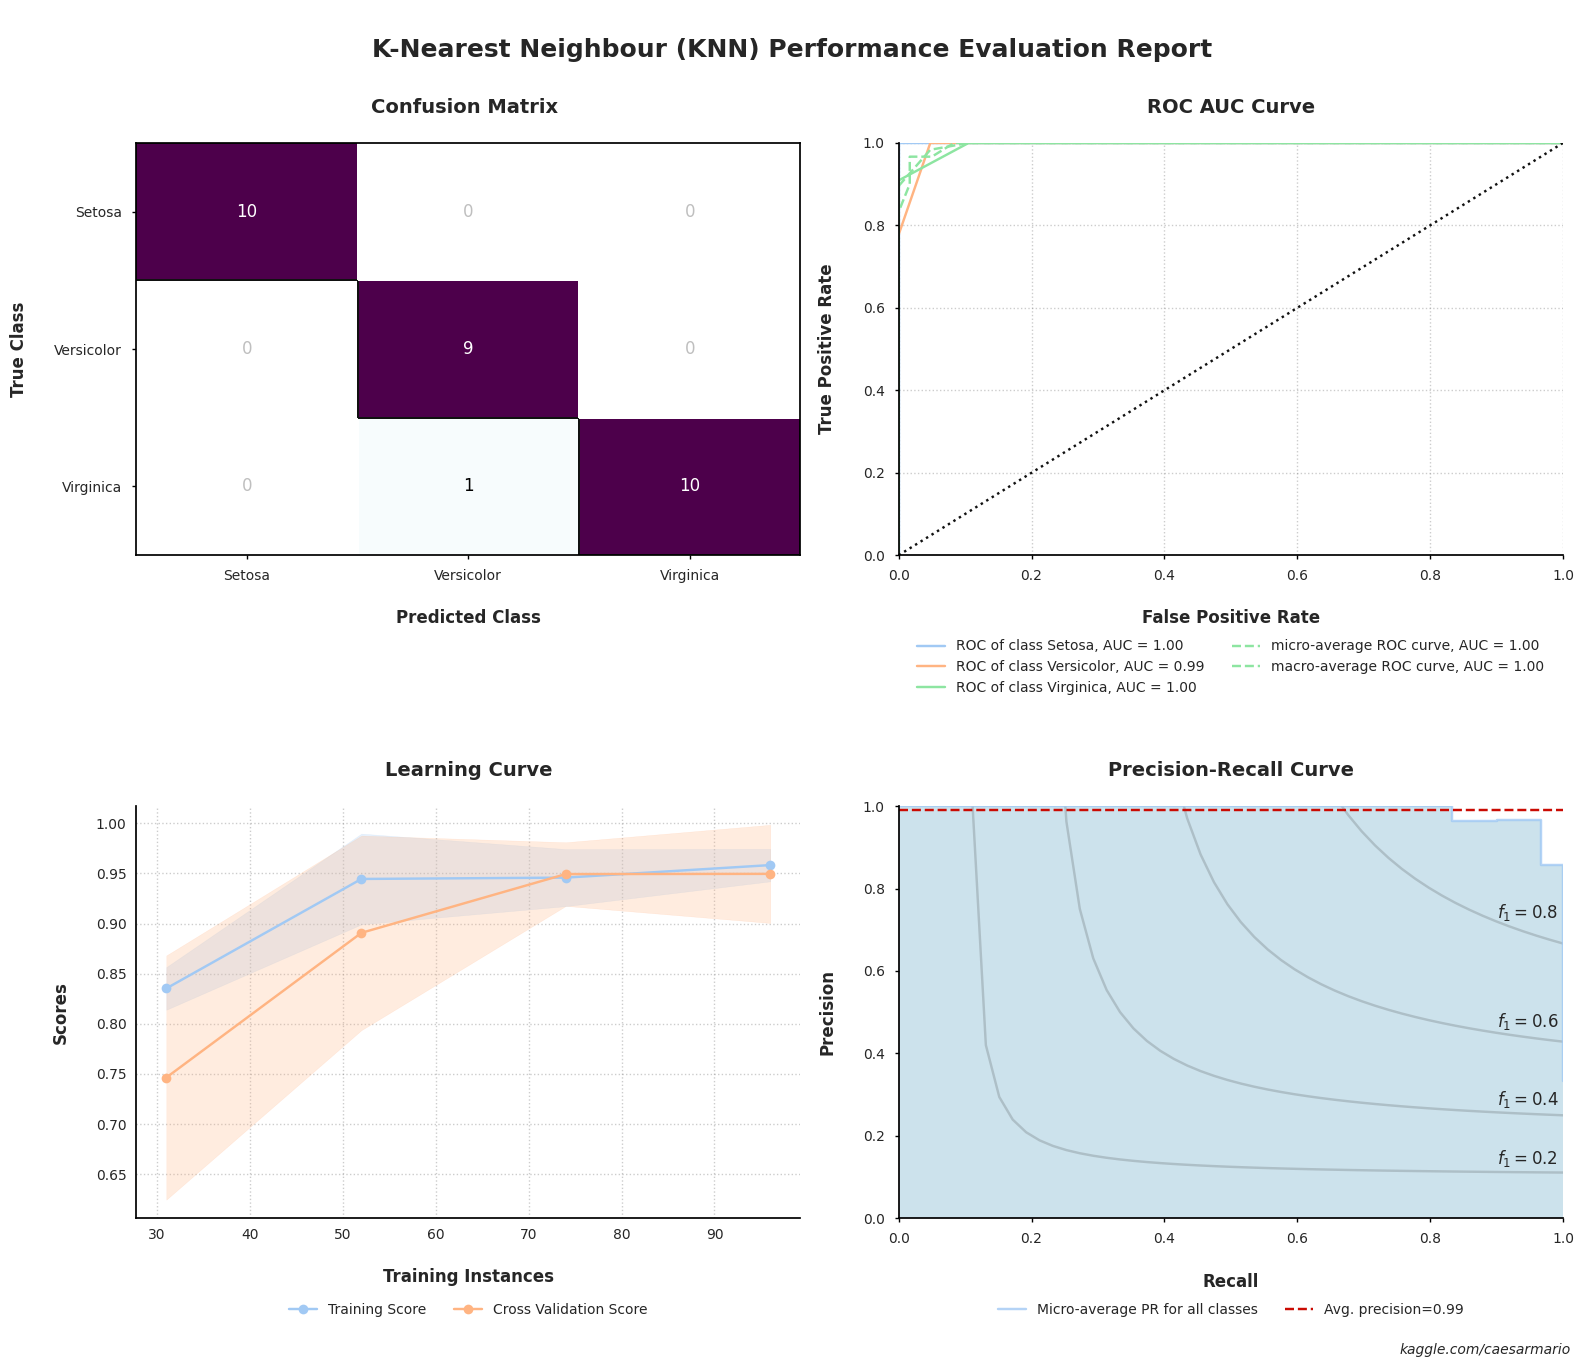

Training Accuracy: 98.333
Testing Accuracy: 96.667
Best Cross-Validation Score: 0.9583


In [ ]:
# KNN parameters
import numpy as np
parameter_knn = {
    'algo__n_neighbors': np.arange(2, 15, 1),
    'algo__leaf_size': np.arange(1, 11, 1)
}

# KNN Algorithm
algo_knn = KNeighborsClassifier()

# Applying KNN
acc_score_train_knn, acc_score_test_knn, best_score_knn = fit_ml_models(algo_knn, parameter_knn, 'K-Nearest Neighbour (KNN)')

print(f'Training Accuracy: {acc_score_train_lr}')
print(f'Testing Accuracy: {acc_score_test_lr}')
print(f'Best Cross-Validation Score: {best_score_lr}')

## Decision Tree
Decision Tree is a Supervised learning technique that can be used for both Classfication and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In a Decision tree, there are two nodes, which are the Decision Node and Leaf Node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches:

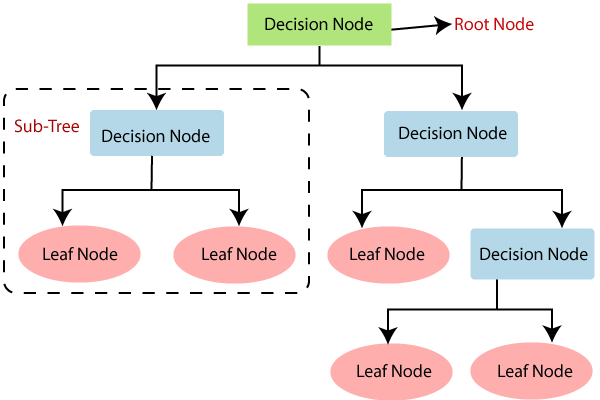

.:. Fitting Decision Tree .:.
Fitting 10 folds for each of 10 candidates, totalling 100 fits

>> Best Parameters: {'algo__max_depth': 3}
>> Best Score: 0.942

.:. Train and Test Accuracy Score for Decision Tree .:.
	>> Train Accuracy:95.83%
	>> Test Accuracy:96.67%

.:. Classification Report for Decision Tree .:.
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



Feature importance visualization failed: Invalid RGBA argument: 'p'


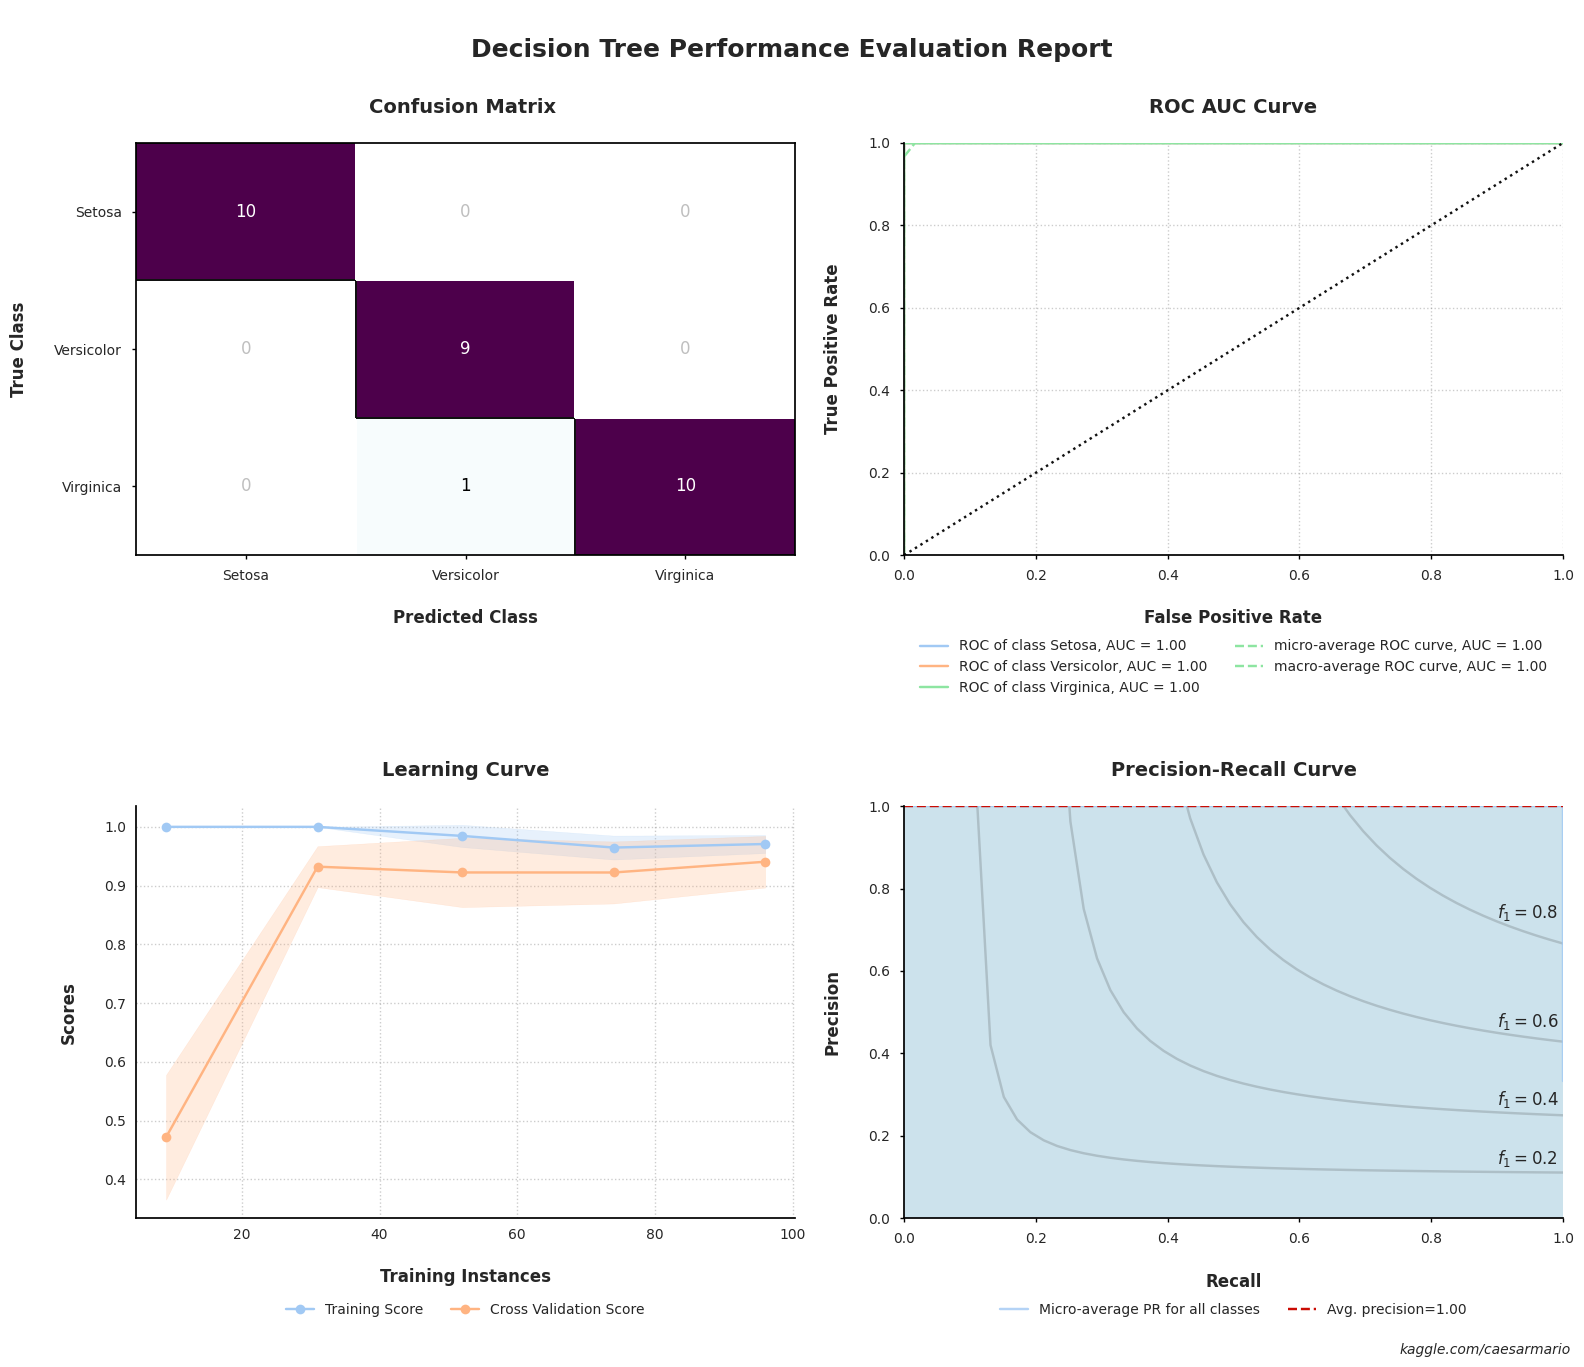

In [ ]:
# decision tree params
params_dt = {'algo__max_depth': np.arange(1, 11, 1)}

# decision tree algorithm
algo_dt = DecisionTreeClassifier(random_state=42)

# applying decision tree
acc_score_train_dt, acc_score_test_dt, best_score_dt = fit_ml_models(algo_dt, params_dt, 'Decision Tree')

## Gaussian Naive Bayes
Naive Bayes Classifiers are based on the Bayes Theorem, which one assumption taken is the strong independence assumptions between the features. These classifiers assume that the value of a particular feature is independent of the value of any other feature. Naive Bayes classifiers need a small training data to estimate the parameters needed for classification. Naive Bayes Classifiers have simple design and implementation and they can applied to many real life situations.

Gaussian Naive Bayes is a variant of Naive Bayes that follows Gaussian normal distribution and supports continuous data. When working with continuous data, an assumption often taken is that the continuous values associated with each class are distributed according to a normal (or Gaussian) distribution.
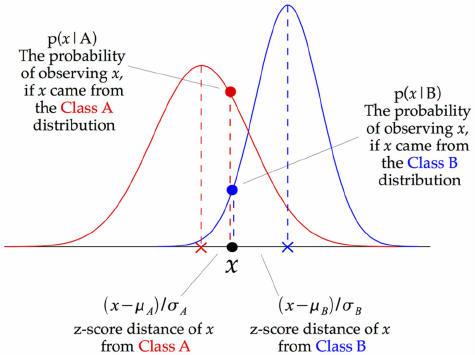

.:. Fitting Gaussian Naive Bayes .:.
Fitting 10 folds for each of 5 candidates, totalling 50 fits

>> Best Parameters: {'algo__var_smoothing': 0.01}
>> Best Score: 0.942

.:. Train and Test Accuracy Score for Gaussian Naive Bayes .:.
	>> Train Accuracy:95.00%
	>> Test Accuracy:96.67%

.:. Classification Report for Gaussian Naive Bayes .:.


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



Feature importance visualization failed: could not find feature importances param on GaussianNB


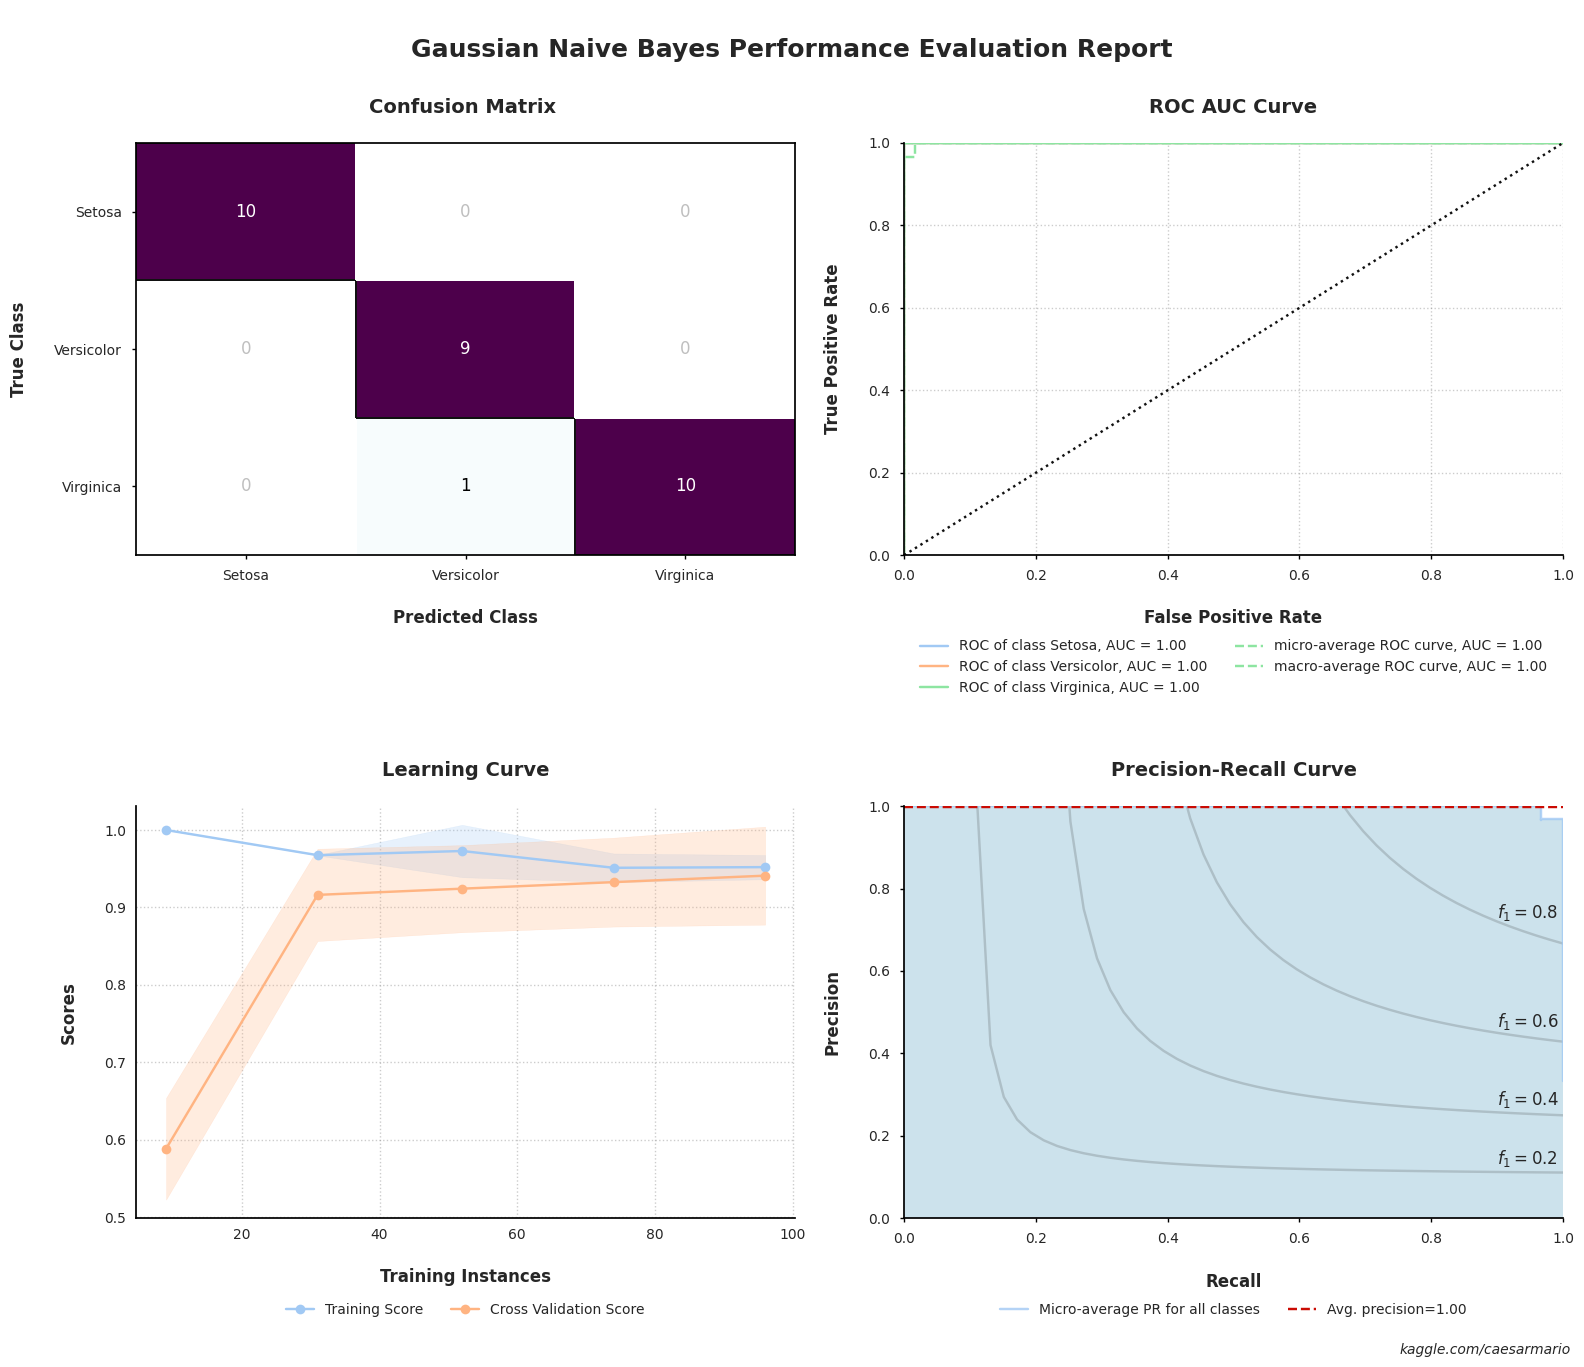

In [ ]:
# gaussian NB params
params_gnb = {'algo__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}

# gaussian NB algorithm
algo_gnb = GaussianNB()

# applying gaussian NB

acc_score_train_gnb, acc_score_test_gnb, best_score_gnb = fit_ml_models(algo_gnb, params_gnb, 'Gaussian Naive Bayes')

## Model Comparison
After implementing and tuning 5 models, this section will compare all machine learning accuracy and best score.

In [ ]:
# Create accuracy comparison table
df_compare = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbor', 'Support Vector Machine', 'Gaussian NB', 'Decision Tree'],
    'Accuracy Train': [acc_score_train_lr, acc_score_train_knn, acc_score_train_svc, acc_score_train_gnb, acc_score_train_dt],
    'Accuracy Test': [acc_score_test_lr, acc_score_test_knn, acc_score_test_svc, acc_score_test_gnb, acc_score_test_dt],
    'Best Score': [best_score_lr, best_score_knn, best_score_svc, best_score_gnb, best_score_dt]
})

# Print model comparison title
print(clr.start + 'Model Comparison' + clr.end)

# Sort the DataFrame by 'Best Score' column in descending order
df_compare_sorted = df_compare.sort_values(by='Best Score', ascending=False)

# Hide the index column using set_table_styles
styled_df = df_compare_sorted.style.set_table_styles([{'selector': 'caption', 'props': [('display', 'none')]}])

# Display the styled DataFrame
display(styled_df)

Model Comparison


,Model,Accuracy Train,Accuracy Test,Best Score
0,Logistic Regression,98.333000,96.667000,0.958300
1,K-Nearest Neighbor,95.833000,96.667000,0.958300
2,Support Vector Machine,96.667000,96.667000,0.958300
3,Gaussian NB,95.000000,96.667000,0.941700
4,Decision Tree,95.833000,96.667000,0.941700


From the results of the accuracy of the train and test above, all models get a perfect score, where the score of all models is above 0.94. It can be seen that the two models have the highest score, with a score of 0.95, namely SVM and K-Nearest Neighbor. In addition, all models have train and test accuracy above 90%, which means all models are very good at classifying Iris flower types. However, some models experience a little underfitting since the test accuracy is higher than the test, except for SVM, which has a good fit because the train and test accuracy have the same value.

When viewed from the ROC AUC Curve, all models have an AUC value close to 1,which means that all models can predict the classification of the Iris type well. Similarly, the confusion matrix shows that the prediction results of all models are the same. Judging from the F1 scores of all models, all models are good at differentiating the Iris type. The precision value for all models also has the same results, where all models can 100% accurately define Setosa and Virginica, while only 90% accuracy can define Versicolor.  Furthermore, both training and validation scores for the learning curve in all models indicate that all models suffer from low variance and high bias since the lines stay close together. In other words, the models need to generalize the data better. From the analysis above, it can be concluded that SVM is the best model because SVM has a high score and does not experience underfitting.

From the SVM and other models feature importance plot, sepal width is the most significant feature in classifying Iris types. At the same time, other variables such as petal length, petal width, and sepal length have negative values in classifying Iris types which means that some models assume that these variables can have a detrimental impact or no influence on the classification.

# Miscellaneous

This section focuses on creating a complete pipeline, starting from data processing machine learning pipeline, using the best model concluded in the previous section and exporting it to joblib and pickle (.pkl) files. Besides that, test dataset predicted results would also be exported along with actual results in CSV and JSON files. Moreover, this section will also make predictions on dummy data (data generated using Python functions) and export them to CSV and JSON files.

## Creating outputs
The complete pipeline will be exported in this section. The pipeline will be stored using the joblib library into **joblib** and **pickle (.pkl)** files. This section will also show the test data frame before exporting the predicted results and the actual results to the CSV and JSON files.

In [ ]:
# Ensure the output directories exist
pipeline_dir = 'output_pipeline'
if not os.path.exists(pipeline_dir):
    os.makedirs(pipeline_dir)

file_name = 'pipeline_iris_svm_caesarmario'
file_path = os.path.join(pipeline_dir, file_name)

# Create a complete pipeline with preprocessing and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example of a preprocessing step
    ('algo', SVC(C=0.4, kernel='linear', random_state=1, probability=True))
])

# Fit the pipeline
svm_pipeline.fit(x_train, y_train)

# Save the complete pipeline using joblib and pickle
for ext in ['joblib', 'pkl']:
    joblib.dump(svm_pipeline, f'{file_path}.{ext}')

# Create test output dataframe
y_pred_svm = svm_pipeline.predict(x_test)
pred_target = pd.DataFrame(y_pred_svm, columns=['pred_target'])

x_test_output = x_test.reset_index()
actual_target = y_test.to_frame(name='actual_target').reset_index()

# Combine and create test output dataframe
df_test_output = pd.concat([x_test_output, actual_target, pred_target], axis=1).drop('index', axis=1)

# Show sample test output dataframe
print(clr.start + 'Sample Test Dataframe' + clr.end)
print('*' * 28)
print(df_test_output.sample(n=6, random_state=24))

# If you want to style the output using pandas Styler (assuming act_vs_pred is a valid function)
# styled_df = df_test_output.sample(n=6, random_state=24).style.apply(act_vs_pred, axis=1)
# display(styled_df)

Sample Test Dataframe
****************************
    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm    actual_target  \
10            6.5           3.2            5.1           2.0   Iris-virginica   
12            5.5           3.5            1.3           0.2      Iris-setosa   
26            6.7           2.5            5.8           1.8   Iris-virginica   
8             6.2           2.2            4.5           1.5  Iris-versicolor   
6             5.6           2.9            3.6           1.3  Iris-versicolor   
27            6.8           3.2            5.9           2.3   Iris-virginica   

        pred_target  
10   Iris-virginica  
12      Iris-setosa  
26   Iris-virginica  
8    Iris-virginica  
6   Iris-versicolor  
27   Iris-virginica  


In [ ]:
data_file = 'data'
if not os.path.exists(data_file):
    os.makedirs(data_file)

# Export to CSV and JSON files
output_name = 'test_data_iris'
df_test_output.to_csv(f'{data_file}/{output_name}.csv', index=False, sep=',', encoding='utf-8')
df_test_output.to_json(f'{data_file}/{output_name}.json', orient='index')

## Prediction case

predict the dummy data generated using Python functions. Then, the prediction results will be exported as CSV and JSON files.

In [ ]:
# create prediction case function

def create_prediction_case(data, num_rows):
    """
    Create a DataFrame with the same structure as 'data' containing 'num_rows' rows.
    The function samples with replacement from the provided data.
    """
    return data.sample(n=num_rows, replace=True, random_state=42).reset_index(drop=True)

# --- Creating Prediction Case Dataframe (100 Rows) ---
df_pred_case = create_prediction_case(x_train, 100)

# --- Showing Dataframe ---
print(clr.start+"Prediction Case Dataframe"+clr.end)
print("*" * 32)
df_pred_case.sample(n=6, random_state=24).style.background_gradient(cmap="RdPu").hide()

Prediction Case Dataframe
********************************


SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
5.700000,4.400000,1.500000,0.400000
4.600000,3.400000,1.400000,0.300000
6.100000,3.000000,4.600000,1.400000
6.300000,2.500000,5.000000,1.900000
5.200000,3.500000,1.500000,0.200000
4.900000,2.500000,4.500000,1.700000


In [ ]:
# Creating Prediction Case Dataframe (100 Rows)
df_pred_case = create_prediction_case(x_train, 100)

# Creating prediction using the best model
y_pred_case = svm_pipeline.predict(df_pred_case)

# Combining prediction case dataframe with prediction
pred_case_target = pd.DataFrame(y_pred_case, columns=['pred_target'])
df_pred_case_combined = pd.concat([df_pred_case, pred_case_target], axis=1)

# Define a function for styling the DataFrame
def highlight_predictions(row):
    return ['background-color: black'] * len(row)

# Showing final DataFrame
print("Final Prediction Case Dataframe")
print("*" * 38)
styled_pred_case_df = df_pred_case_combined.sample(n=6, random_state=24).style.apply(highlight_predictions, axis=1)
display(styled_pred_case_df)

Final Prediction Case Dataframe
**************************************


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,pred_target
26,5.700000,4.400000,1.500000,0.400000,Iris-setosa
31,4.600000,3.400000,1.400000,0.300000,Iris-setosa
37,6.100000,3.000000,4.600000,1.400000,Iris-versicolor
86,6.300000,2.500000,5.000000,1.900000,Iris-virginica
76,5.200000,3.500000,1.500000,0.200000,Iris-setosa
14,4.900000,2.500000,4.500000,1.700000,Iris-virginica


In [ ]:
# export to csv and json files
pred_output_name = 'pred_case'
df_pred_case.to_csv(f'{pred_output_name}.csv', index=False, sep=',', encoding='utf-8')
df_pred_case.to_json(f'{pred_output_name}.json', orient='index')

# Unsupervised Learning Model Implementation
Implement one of the unsupervised models, namely K-Means. The purpose is to demonstrate how to perform statistical test before implementing the model, perform PCA and implement the K-Means.

## Hopkins Test

This section performs a statistical test using Hopkins statistical test for the preprocessed dataset to measure the clustering tendency of data (measure to what degree clusters exist in the data to be clustered)

The following is the hypotheses:
- H0: the dataset is not uniformly distributed (contains meaningful clusters)
- H1: the dataset is uniformly distributed (no meaningful clusters).

Criteria:
- if the value is between {0.7,...,0.99} accept H0 (it has a high tendency to cluster).

In [ ]:
# Hopkins Test
def hopkins(X):
  d = X.shape[1]
  n = len(X)
  m = int(0.1 * n)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)

  rand_X = sample(range(0,n,1), m)
  ujd = []
  wjd = []
  for j in range(0, m):
    u_dist, _=nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(X, axis=0),d).reshape(1,-1), 2, return_distance=True)
    ujd.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1,-1), 2, return_distance=True)
    wjd.append(w_dist[0][1])

  H = sum(ujd) / (sum(ujd) + sum(wjd))
  if isnan(H):
    print(ujd, wjd)
    H = 0
  return H;

In [ ]:
# perform hopkins test
class Clr:
    start = '\033[1m'
    end = '\033[0m'
    color = '\033[94m'

clr = Clr()

hopkins_value = hopkins(x)
hopkins_result = 'Result: '+clr.start+'{:.4f}'.format(hopkins_value)+clr.end
print(clr.start+'Hopkins Test:'+clr.end)
print(clr.color+'*' * 19+clr.end)
print(hopkins_result)
if 0.7 < hopkins_value < 0.99:
    print(f'>> From the result above, {clr.color}it has a high tendency to cluster (contains meaningful clusters){clr.end}')
    print(f'{clr.start}Conclusions: Accept H0{clr.end}')
    print(f'{clr.color}{"*" * 31}{clr.end}')
else:
    print(f'>> From the result above, {clr.color}it has no meaningful clusters{clr.end}')
    print(f'\n{clr.color}{"*" * 31}{clr.end}')
    print(f'{clr.start}.:. Conclusions: Reject H0 .:. {clr.end}')
    print(f'{clr.color}{"*" * 31}{clr.end}')


Hopkins Test:
*******************
Result: 0.8621
>> From the result above, it has a high tendency to cluster (contains meaningful clusters)
Conclusions: Accept H0
*******************************


## PCA
Principal component analysis (PCA) is a method used in unsupervised machine learning (such as clustering) that reduces high-dimension data to smaller dimensions while preserving as much information as possible. By using PCA before applying clusering algorithm, it allows to reduces dimensions, data noise, and decrease computation cost. The number of features will be reduced to 2 dimensions so that clustering results can be visualized.

In [ ]:
# transform into array
x_pca = np.asarray(x)
# applying PCA
pca = PCA(n_components=2, random_state=24)
x_pca = pca.fit_transform(x_pca)

## Implementing K-Means

After performing the Hopkins test and PCA, the next step is implementing K-Means to the prepared dataset.
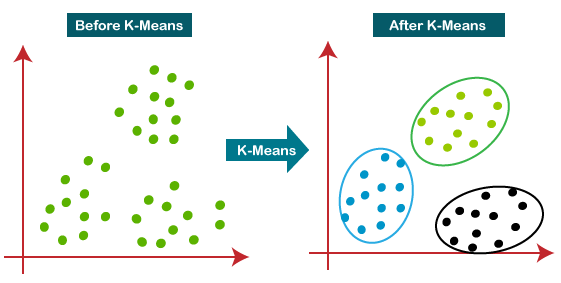
K-Means clustering is a simple unsupervised learning algorithm that is used to solve clustering problems. It follows a simple procedure of classifying a given dataset into a number of clusters, defined by the letter 'k', which is fixed beforehand. The clusters are then positioned as points and all observations or data points are associated with the nearest cluster, computed, adjusted and then the process starts over using the new adjustments until a desired result is reached.
However, it is required to calculate the optimal number of clusters using the elbow score before implementing the K-Means. In addition, the Calinski-Harabasz index will be utilized to determine the ideal number of clusters.

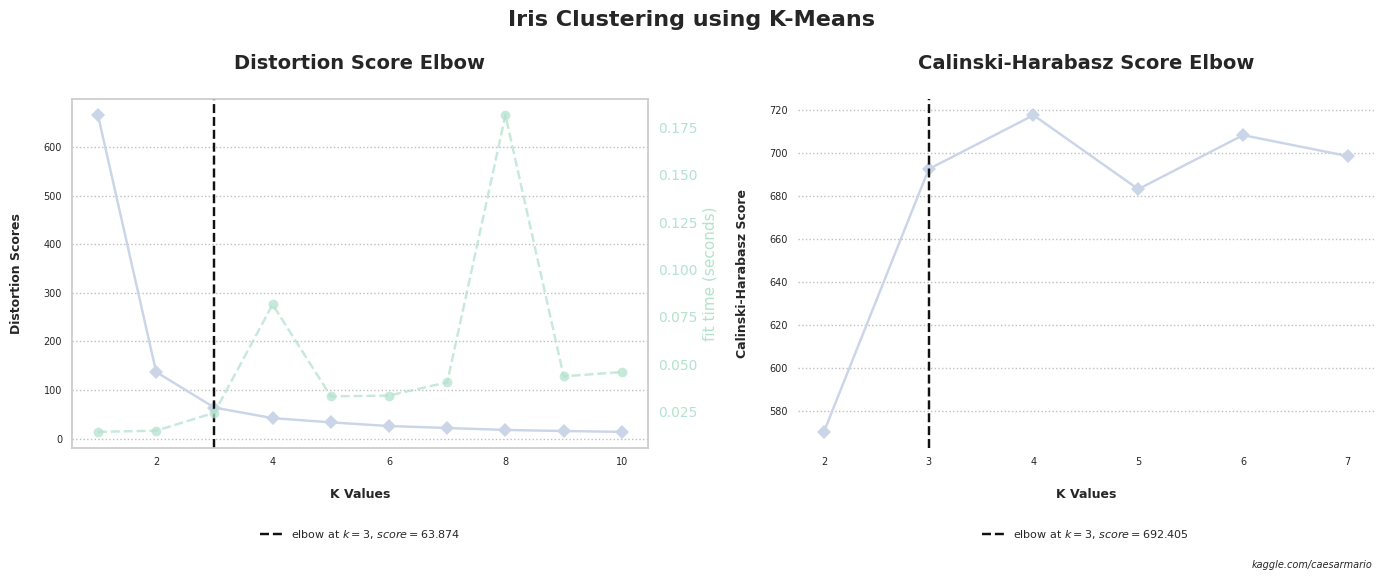

In [ ]:
# define K-Means functions
color_yb_clustering = ["#cbd5e8", "#b3e2cd", "#fdcdac", "#f4cae4", "#fff2ae", "#e6f5c9"]
def kmeans(X):
   # Figure settings
    set_palette(color_yb_clustering)
    title = dict(fontsize=14, fontweight='bold', fontname=font_main)
    text_style = dict(fontweight='bold', fontname=font_main)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  # K-Means
    model = KMeans(random_state=4)

    # Elbow Score
    elbow_score = KElbowVisualizer(model, k=(1, 11), ax=ax1)
    elbow_score.fit(X)
    elbow_score.finalize()
    elbow_score.ax.set_title('Distortion Score Elbow\n', **title)
    elbow_score.ax.tick_params(labelsize=7)
    for text in elbow_score.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in elbow_score.ax.spines.values():
        spine.set_color('None')
    elbow_score.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score.ax.grid(axis='y', alpha=0.5, color=color_grid, linestyle='dotted')
    elbow_score.ax.grid(axis='x', alpha=0)
    elbow_score.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score.ax.set_ylabel('Distortion Scores\n', fontsize=9, **text_style)

    # Elbow Score (Calinski Harabasz Index)
    elbow_score_ch = KElbowVisualizer(model, k=(2, 8), metric='calinski_harabasz', timings=False, ax=ax2)
    elbow_score_ch.fit(X)
    elbow_score_ch.finalize()
    elbow_score_ch.ax.set_title('Calinski-Harabasz Score Elbow\n', **title)
    elbow_score_ch.ax.tick_params(labelsize=7)
    for text in elbow_score_ch.ax.legend_.texts:
        text.set_fontsize(9)
    for spine in elbow_score_ch.ax.spines.values():
        spine.set_color('None')
    elbow_score_ch.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score_ch.ax.grid(axis='y', alpha=0.5, color=color_grid, linestyle='dotted')
    elbow_score_ch.ax.grid(axis='x', alpha=0)
    elbow_score_ch.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score_ch.ax.set_ylabel('Calinski-Harabasz Score\n', fontsize=9, **text_style)

    plt.suptitle('Iris Clustering using K-Means', fontsize=16, **text_style)
    plt.gcf().text(0.9, 0.05, 'kaggle.com/caesarmario', style='italic', fontsize=7, fontname=font_alt)
    plt.tight_layout()
    plt.show()

# Assuming x_pca is already defined
kmeans(x_pca)



Based on the results of the elbow method and Calinski Harabasz score above, it can be concluded that the best clustering number for the K-Means algorithm is 3 clusters. The following steps will apply the number of optimal clusters, visualize clusters distribution plot and silhouette plots to evaluate their performance.

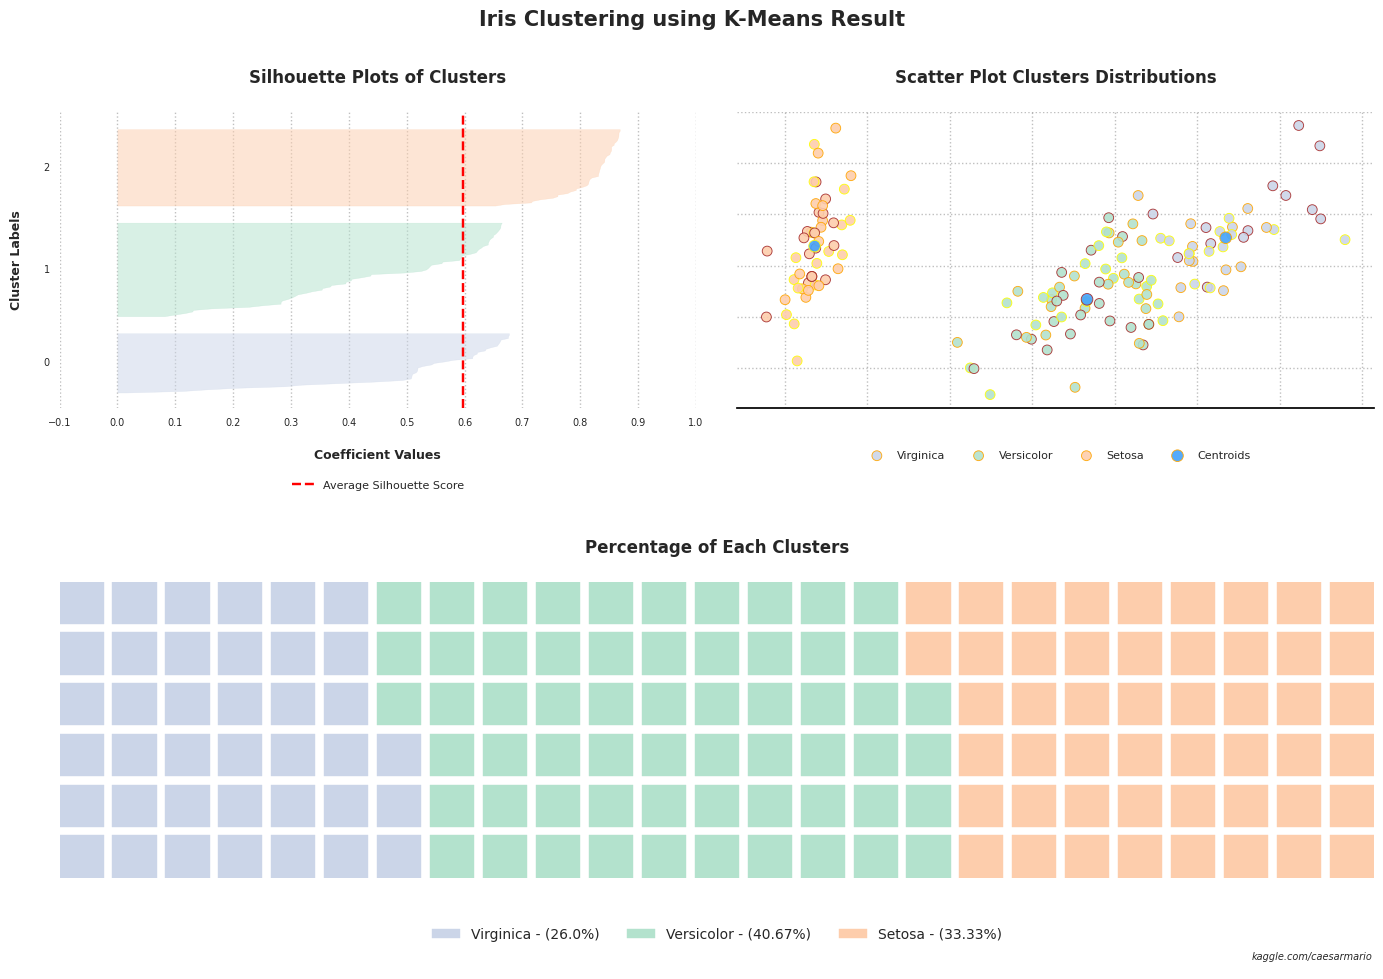

In [ ]:
# Implementing K-Means
cluster_colors = ["#cbd5e8", "#b3e2cd", "#fdcdac"]
kmeans = KMeans(n_clusters=3, random_state=4)
y_kmeans = kmeans.fit_predict(x_pca)

# define K-Means Visualiser & Plots
def visualizer(X, kmeans, y_kmeans):
  # figure settings
  labels = ['Virginica', 'Versicolor', 'Setosa', 'Centroids']
  title = dict(fontsize=12, fontweight='bold', fontname=font_main)
  text_style = dict(fontweight='bold', fontname = font_main)
  scatter_style = dict(linewidth=0.65, edgecolor=scatter_color_edge, alpha=0.9)
  legend_style = dict(borderpad=2, frameon=False, fontsize=8)
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

  # Silhouette Plots
  s_viz = SilhouetteVisualizer(kmeans, ax=ax1, colors=cluster_colors)
  s_viz.fit(X)
  s_viz.finalize()
  s_viz.ax.set_title('Silhouette Plots of Clusters\n', **title)
  s_viz.ax.tick_params(labelsize=7)
  for text in s_viz.ax.legend_.texts:
    text.set_fontsize(9)
  for spine in s_viz.ax.spines.values():
    spine.set_color('None')
  s_viz.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), **legend_style)
  s_viz.ax.grid(axis='x', alpha=0.5, color=color_grid, linestyle='dotted')
  s_viz.ax.grid(axis='y', alpha=0)
  s_viz.ax.set_xlabel('\nCoefficient Values', fontsize=9, **text_style)
  s_viz.ax.set_ylabel('Cluster Labels\n', fontsize=9, **text_style)

  # Clusters Distribution
  y_kmeans_labels = list(set(y_kmeans.tolist()))
  for i in y_kmeans_labels:
    ax2.scatter(X[y_kmeans==i, 0], X[y_kmeans == i, 1], s=50, c=cluster_colors[i], **scatter_style)
  ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='#42A2FC', label='Centroids', **scatter_style)
  for spine in ax2.spines.values():
    spine.set_color('None')
  ax2.set_title('Scatter Plot Clusters Distributions\n', **title)
  ax2.legend(labels, bbox_to_anchor=(0.85, -0.05), ncol=5, **legend_style)
  ax2.grid(axis='both', alpha=0.5, color=color_grid, linestyle='dotted')
  ax2.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
  ax2.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
  ax2.spines['bottom'].set_visible(True)
  ax2.spines['bottom'].set_color(color_line)

  # Waffle Chart
  unique, counts = np.unique(y_kmeans, return_counts=True)
  df_waffle = dict(zip(unique, counts))
  df_waffle = {'Virginica' if k == 0 else 'Versicolor' if k == 1 else 'Setosa' if k == 2 else k:v for k,v in df_waffle.items()}
  total = sum(df_waffle.values())
  wfl_square = {key: value for key , value in df_waffle.items()}
  wfl_label = {key: round(value/total*100, 2) for key, value in df_waffle.items()}

  ax3=plt.subplot(2, 2, (3,4))
  ax3.set_title('Percentage of Each Clusters\n', **title)
  ax3.set_aspect(aspect='auto')
  Waffle.make_waffle(ax=ax3, rows=6, values=wfl_square, colors=cluster_colors, labels=[f'{i} - ({k}%)' for i, k in wfl_label.items()],
                     legend={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.05),
                             'ncol': 4, 'borderpad': 2, 'frameon': False, 'fontsize': 10})
  # suptitle & WM
  plt.suptitle('Iris Clustering using K-Means Result\n', fontsize=15, **text_style)
  plt.gcf().text(0.9, 0.03, 'kaggle.com/caesarmario', style='italic', fontsize=7)
  plt.tight_layout()
  plt.show();

# Calling K-Means Functions
visualizer(x_pca, kmeans, y_kmeans);


The image above illustrates each cluster's silhouette coefficient values, each cluster distribution in the scatter plot, and each customer's number in a cluster. From the silhoutte clusters, the silhouette value of each cluster is above the average, indicating all clusters are optimal. However, from the fluctuations of the silhouette plot size, Setosa has very wide fluctuations compared to other clusters (the other clusters fluctuations look 'sharper'). In addition, from the thickness, Setosa has a thicker consistency than other clusters.
- Davis-Bouldin Index is a metric for evaluating clustering algorithms. It is defined as a ratio between the cluster scatter and the cluster's separation. Scores range from 0 and up. 0 indicates better clustering.
- Silhouette Coefficient/Score is a metric used to calculate the goodness of a clustering technique. Its value range from -1 to 1. The higher the score, the better. 1 means clusters are well apart from each other and clearly distinguished. 0 means clusters are indifferent/the distance between clusters is not significant.
- Calinski-Harabasz Index (variance ratio criterion), is the ratio of the sum of between-clusters dipersion and of inter-cluster dispersion for all clusters, the higher the score, the better the performance.

In [ ]:
# Evaluate clustering quality function
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
def evaluate_clustering(X, y):
  db_index = round(davies_bouldin_score(X, y), 3)
  s_score = round(silhouette_score(X, y), 3)
  ch_index = round(calinski_harabasz_score(X, y), 3)
  print(clr.start+'Evaluate Clustering Quality'+clr.end)
  print('*' * 34+clr.end)
  print('Davies-Bouldin Index: '+clr.start, db_index)
  print(clr.end+'Silhouette Score: '+clr.start, s_score)
  print(clr.end+'Calinski Harabasz Index:'+clr.start, ch_index)
  return db_index, s_score, ch_index

# evaluate K-Means Cluster Quality
db_kmeans, ss_kmeans, ch_kmeans = evaluate_clustering(x_pca, y_kmeans)

Evaluate Clustering Quality
**********************************
Davies-Bouldin Index:  0.565
Silhouette Score:  0.598
Calinski Harabasz Index: 692.405


Based on the evaluation score above, the clustering quality using K-Means with 3 clusters is decent. This is because all data points in Setosa are completely separated from those data points in Virginica and Versicolor. Silhouette score also shows that the clustering technique using K-Means is viable.

## Cluster Profiling
Performing cluster profiling to identify the characteristics of the clusters that have been created by K-Means

In [ ]:
# add k-means prediction to dataframe
df['cluster_result'] = y_kmeans+1
iris_type = {
    1: 'Virginica',
    2: 'Versicolor',
    3: 'Setosa'
}
df['cluster_result'] = df['cluster_result'].replace(iris_type).astype(str)

# calculating overall mean from the current data frame
df_profile_overall = pd.DataFrame()
df_profile_overall['Overall'] = df.describe().loc[['mean']].T

# summarize mean of each clusters
df_cluster_summary = df.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0':'Column Name', 'level_1': 'Metrics'})
df_cluster_summary = df_cluster_summary[df_cluster_summary['Metrics'] == 'mean'].set_index('Column Name')

# combining both data frame
print(clr.start+'Summarize of Each Clusters'+clr.end)
print('*' * 33)
df_profile = df_cluster_summary.join(df_profile_overall).reset_index()
df_profile.style.background_gradient(cmap='RdPu').hide()

Summarize of Each Clusters
*********************************


Column Name,Metrics,Setosa,Versicolor,Virginica,Overall
SepalLengthCm,mean,5.006000,5.883607,6.853846,5.843333
SepalWidthCm,mean,3.418000,2.740984,3.076923,3.054000
PetalLengthCm,mean,1.464000,4.388525,5.715385,3.758667
PetalWidthCm,mean,0.244000,1.434426,2.053846,1.198667


Based on the table above, it can be concluded that each Iris type has the following characteristics:
- Setosa: Iris Setosa has the smallest sepal length, petal length, and petal width characteristics compared to other species, namely Versicolor and
Virginica. However, this species has the widest sepal width. So, it can be concluded Iris Setosa is the Iris flower with the smallest characteristics. This is also proven by the scatter plot in the previous section, where the data points for this type are completely separated from the data points of Virginica and Versicolor and are located on the left.
- Versicolor: Iris Versicolor has characteristics of width and length of petals and sepals close to Virginica. However, Versicolor has the smallest sepal width compared to the other two types, which are Setosa and Versicolor. So it can be concluded that Iris Versicolor is an Iris flower with characteristics between Setosa and Virginica, where the size is not too small and not too large. From the scatter plot, Versicolor data points are in the middle and quite close to Virginica data points.
- Virginica: Iris Virginica is characterized by the largest width and length of petals and wider sepals compared to Versicolor. From this, it can be concluded that Virginica has the largest size characteristics compared to the other two species. This is also evident from the scatter plot, where Virginica data points are located on the middle, right after Versicolor.

# Conclusions:
From the results of EDA, supervised and unsupervised machine learning models implementation in the previous section, it can be concluded as follows:
- Various data visualization techniques were used to do an extensive investigation, which helped find insightful information about the fundamental relationships and patterns in the Iris dataset.
- This notebook successfully implemented both supervised and unsupervised machine learning models, comparing its result and performance and choosing the best model that is the most effective classifiers for the Iris dataset. Furthermore, evaluation techniques have been implemented and well-visualized.

References:
- https://www.datacamp.com/tutorial/naive-bayes-scikit-learn
- https://www.kaggle.com/code/caesarmario/petal-profiling-classification-clustering/notebook

In [94]:
!git clone https://github.com/alyahoang99/classfication-clustering

Cloning into 'classfication-clustering'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), done.


In [96]:
%cd classfication-clustering

/content/classfication-clustering
